# Word2Vec (Negative Sampling) 

2 things we need to add
- how to smaple the negative smaples
- the process of gerring the negative samples

1 thing we need to change : model

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.23.4', '1.13.1+cpu')

In [3]:
import matplotlib
matplotlib.__version__

'3.5.1'

## 1. Load data

In [4]:
#specify the sentences / corpus 
#corpus is define as set of document
#document is basically a nuch of sentence(s)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple", 
          "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

In [5]:
#1. tokenize
#usually you use spaCy/ NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized #we called each of this as 'tokens' NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

In [6]:
#2. numericalize (vocab)

#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized))) #vocabs is a term degining all unique words your system know

In [7]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}
word2index

{'dog': 0,
 'animal': 1,
 'cat': 2,
 'apple': 3,
 'fruit': 4,
 'banana': 5,
 'grape': 6,
 'fish': 7}

In [8]:
word2index['dog']

0

In [9]:
#add <UNK>, which is a very normal token exits in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKK, or anything

In [10]:
#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = 6 #usually <UNK> is 0

In [11]:
#create index2word dictionary
# index2word = {idx: v for idx, v in enumerate(vocabs)}
# index2word

# for key,value in word2index.items():
#     print(key,value)

index2word = {v:k for k,v in word2index.items()}
index2word

{0: 'dog',
 1: 'animal',
 2: 'cat',
 3: 'apple',
 4: 'fruit',
 5: 'banana',
 6: '<UNK>',
 7: 'fish'}

## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [12]:
#move along the corpus
#to fit with our corus, we gonna use window_size = 1
skipgrams =[]
#for each corpus
for sent in corpus_tokenized:
    #for each sent ('apple', 'banana', 'fruit')
    for i in range(1,len(sent)-1): #start from 1 to second last
        # print(sent[i])
        center_word = sent[i]
        outside_word = [sent[i-1],sent[i+1]] #window_size =1
        #here we want to create (banana, apple), (banana, fruit) append to some list
        for o in outside_word:
            skipgrams.append([center_word,o])
skipgrams

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['apple', 'grape'],
 ['apple', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog'],
 ['dog', 'fish'],
 ['dog', 'dog']]

In [13]:
# corpus = [  'apple banana fruit','banana apple fruit','banana fruit apple',
#             'dog cat animal', 'cat dog animal', 'cat animal dog']

In [14]:
#let's make what we have made into a fucntion (batch function)
#return a batches of data, e.g., = 2 --> ['banana', 'apple'],['banana','fruit']
#also i want these batches ti be id, NOT token --> [5,4]

def random_batch(batch_size, corpus):
    skipgrams =[]
    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(1,len(sent)-1): #start from 1 to second last
            # print(sent[i])
            center_word = word2index[sent[i]]
            outside_word = [word2index[sent[i-1]],word2index[sent[i+1]]] #window_size =1
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                skipgrams.append([center_word,o])
    #only get a batch, mot the entire lsit
    random_index = np.random.choice(range(len(skipgrams)),batch_size,replace=False)
    
    #appending some list of inputs and labels
    random_inputs, random_labels = [] , []
    for index in random_index:
        random_inputs.append([skipgrams[index][0]]) #center words, this will be as shape of (1,) -> (1,1) for modeling
        random_labels.append([skipgrams[index][1]])

    return np.array(random_inputs),np.array(random_labels)

In [15]:
input,label = random_batch(10, corpus_tokenized)

print(f'{input.shape}')
print(f'{label.shape=}')

(10, 1)
label.shape=(10, 1)


## 3. Unigram Distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [16]:
#basically create a distribution of all the words you have in your vocabs

In [17]:
z = 0.0001 #scaling up lower frequency terms

In [18]:
#count all the occurence of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

Counter({'apple': 5,
         'banana': 3,
         'fruit': 3,
         'grape': 1,
         'dog': 5,
         'cat': 3,
         'animal': 3,
         'fish': 1})

In [19]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24

In [20]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha/z)
    # print('Vocab :',v)
    # print('distribution :', uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)

Counter(unigram_table)

Counter({'dog': 3083,
         'animal': 2102,
         'cat': 2102,
         'apple': 3083,
         'fruit': 2102,
         'banana': 2102,
         'grape': 922,
         'fish': 922})

## 4. Negative Sampling

A function to get negavtive samples, based o nthe current center and outsode words in the batch

In [71]:
def prepare_sequence(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [72]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

### Test our negative Sampling method

In [73]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size,corpus_tokenized)

input_batch, label_batch

(array([[3],
        [1]]),
 array([[5],
        [0]]))

In [74]:
input_batch = torch.LongTensor(input_batch)
label_batch  = torch.LongTensor(label_batch)

In [75]:
num_neg = 2 # in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)
# neg_samples[0].shape
neg_samples.shape 

torch.Size([2, 2])

In [76]:
label_batch

tensor([[5],
        [0]])

## 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [83]:
#the model will accept three vectors - u_o, v_c, u_k
#u_o - vectos for outside words
#v_C - vector for center word
#u_k - vectors for negative word

class SkipgramNeg(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(SkipgramNeg,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words  (batch_size,1)
        #negative_words (batch_size,k) 
        center_embed    = self.embedding_center_word(center_words)      #(batch_size,1, emb_size)
        outside_embed   = self.embedding_outside_word(outside_words)   #(batch_size,1, emb_size)
        neg_embed       = self.embedding_outside_word(negative_words)      #(batch_size,k, emb_size)
        
        uovc            = outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc            = -neg_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc_sum        =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum) #(batch_size,1)+(batch_size,1)
        
        return -torch.mean(loss) #scalar, loss should be scalar, to call backward()

### Testing the model

In [84]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)
label_tensor  = torch.LongTensor(label) #longTensor menas integer......

In [85]:
input_tensor.shape,label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [86]:
emb_size = 2 #usually, this can be 50, 100, or 300
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [87]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)
neg_tensor.shape

torch.Size([2, 5])

In [88]:
#this should give one number
loss = model(input_tensor, label_tensor, neg_tensor)

In [89]:
loss

tensor(2.5937, grad_fn=<NegBackward0>)

## 6. Training

In [90]:
voc_size = len(vocabs)
voc_size

batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = SkipgramNeg(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):
    #get random batch
    input_batch, label_batch = random_batch(batch_size,corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch = negative_sampling(label_tensor, unigram_table, 5)
    
    #loss = model
    loss = model(input_batch,label_batch,neg_batch)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1} | Loss {loss:.6f} | Time : ?')

    # break

Epoch 1000 | Loss 0.923760 | Time : ?
Epoch 2000 | Loss 0.606125 | Time : ?
Epoch 3000 | Loss 0.459829 | Time : ?
Epoch 4000 | Loss 0.183600 | Time : ?
Epoch 5000 | Loss 0.184393 | Time : ?


In [92]:
print(input_batch.shape,label_batch.shape,neg_batch.shape)

torch.Size([2, 1]) torch.Size([2, 1]) torch.Size([2, 5])


## 7. Plotting the embeddings

Is really the related studd are close to each other, and vice versa.

The most fun part: Will 'banana' closer to 'fruit' than 'cat'?

In [93]:
vocabs

['dog', 'animal', 'cat', 'apple', 'fruit', 'banana', 'grape', 'fish', '<UNK>']

In [94]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([5])

In [95]:
banana_center_embed = model.embedding_center_word(banana)
banana_outside_embed = model.embedding_outside_word(banana)
banana_embed = (banana_center_embed+banana_outside_embed)/2
banana_embed

tensor([[2.7115, 0.0233]], grad_fn=<DivBackward0>)

In [96]:
#find embedding of fruit, cat
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()
    
print(get_embed('fruit'))
print(get_embed('cat'))
print(get_embed('chaky'))

(4.2000017166137695, -0.5560286045074463)
(-2.8268682956695557, 0.8387230038642883)
(1.0081284046173096, -1.5003467798233032)


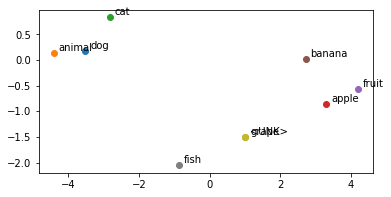

In [97]:
#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

## 8. Cosine Similarity
How do (from Scratch) calcualte cosine similarity?

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [98]:
vocabs

['dog', 'animal', 'cat', 'apple', 'fruit', 'banana', 'grape', 'fish', '<UNK>']

In [99]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [100]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  -0.9877318352503154
cat vs. animal:  0.9675721165825377
cat vs. cat:  1.0000000000000002


In [101]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  -0.9877318352503155
cat vs. animal:  0.9675721165825377
cat vs. cat:  1
